# Project description

## This project will mainly focus on the areas of Tokyo. Let's say new invester decided to open a restaurant in London. It is quite a hard task to decide which area to choose, especially in a big city like Tokyo. That's why I will explore the london data and find out where most of the restaurants are gathered which implies where profit is the highest.

### Import the libraries

In [16]:
!pip install geopy
!pip install geocoder
!pip install folium
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


###  Scrap data from Wikipedia page into a DataFrame

In [31]:
res = requests.get("https://en.wikipedia.org/wiki/Special_wards_of_Tokyo").text
soup = BeautifulSoup(res,'lxml')
Wards_Tokyo_Table = soup.find('table', {'class':'wikitable sortable'}) 


In [32]:
Name=[]
Kanji = []
Pop = []
Density = []
num = []
flag = []
Area = []
Major_District = []

for row in Wards_Tokyo_Table.findAll("tr"):
    #print (row)    
    Ward = row.findAll('td')
    #print (len(Ward))
    print (Ward)
    if len(Ward)==8: #Only extract table body not heading
        print (Ward[0])
        #print postcode[1]
        #print postcode[2]
        num.append(Ward[0].find(text=True))
        flag.append(Ward[1].findAll('a')) # useless
        Name.append(Ward[2])
        Kanji.append(Ward[3].find(text=True))
        Pop.append(Ward[4])
        Area.append(Ward[5].find(text=True))
        Major_District.append(Ward[7].find(text=True))
            
#print (Pop) 


#++++++++++++++++++++++++++++++++++++++++++++++
#+ Area 
#++++++++++++++++++++++++++++++++++++++++++++++

# print (Area[3]) # the first element of the area needs a replacement with the true value 5100
Area = ['5100' if x=='0' else x for x in Area]
New_Area = []

# change the type of Area list 
for l in range(len(Area)):
    x=Area[l].replace(",","")
    print (x)
    New_Area.append(x)

New_Area=[int(s) for s in New_Area]

#print (New_Area) # the list elements are already in accordance with the table

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Name of the Wards
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#print (Name) # want to select only the title part

new_names = []
for n in range(len(Name)):
    print (Name[n])
    names = Name[n].findAll('a')
    new_names.append(names) 

print (new_names)

flat_new_names_list = [item for sublist in new_names for item in sublist]
print (flat_new_names_list)

Wards_names= []
#now 
for name_wards in flat_new_names_list:
        Wards_names.append(name_wards.get('title'))

print (Wards_names)

# replace the elements in the list that contains 'Tokyo' with only the ward names
replace_names={'Chiyoda, Tokyo':'Chiyoda', 'Chūō, Tokyo':'Chuo', 'Minato, Tokyo':'Minato', 
               'Sumida, Tokyo':'Sumida', 'Koto, Tokyo':'Koto', 'Ōta, Tokyo':'Ota', 'Nakano, Tokyo':'Nakano', 
               'Kita, Tokyo':'Kita', 'Arakawa, Tokyo':'Arakawa', 'Adachi, Tokyo':'Adachi', 'Edogawa, Tokyo':'Edogawa'}


Wards_names1 = [replace_names.get(n1,n1) for n1 in Wards_names]

#print (Wards_names1)

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Population
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
# print (len(Pop))
# #print ((Pop[5].text))
population = []
for p in range(len(Pop)):
    print ((Pop[p]))
    pops = Pop[p].text[1:9]
    print (Pop[p].text[1:9])
    #populs = Pop[p].find('visibility:hidden;color:transparent;')
    population.append(pops) 
print (population)


New_population = []
for po in range(len(population)):
    xy=population[po].replace(",","")
    print (xy)
    New_population.append(xy)

New_population=[int(s1) for s1 in New_population]
# print (New_population)



#++++++++++++++++++++++++++++++++++++++++++++++++
#+ Major Districts
#++++++++++++++++++++++++++++++++++++++++++++++++


replace_districts = {'Nagatachō':'Nagatacho', 'Hongō':'Hongo', 'Kinshichō':'Kinshicho', 'Ōmori': 'Omori', 
                     'Kōenji':'Koenji', 'Arakawa, Machiya, ':'Arakawa', 'Ayase, ':'Ayase', 'Kasai, Koiwa\n':'Kasai'}


Major_District_names1 = [replace_districts.get(n2,n2) for n2 in Major_District]


df=pd.DataFrame(Wards_names1,columns=['Ward'])
df['Area_SqKm'] = New_Area
df['Population'] = New_population
df['Major_District'] = Major_District_names1
df.index = np.arange(1, len(df) + 1) # reset the index so that it starts from 1. 

# use of geopy geocoders
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Tokyo_explorer")
df['Major_Dist_Coord']= df['Major_District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
# replace some of the wrong coordinates 


Lat_list = df['Latitude'].tolist()
Long_list = df['Longitude'].tolist()
print ("Old latitude list: ", Lat_list)
print ("Old Longitude list: ", Long_list)
replace_latitudes = {32.5093796:35.7088, 23.0131338:35.6722, -38.9047057:35.5884, -5.3498001:35.6634}
replace_longitudes = {-116.2970014:139.7601, -80.8328748:139.8061, 175.7552111:139.7279, 21.424098:139.8731}

latitudes_new = [replace_latitudes.get(n3,n3) for n3 in Lat_list]
longtitudes_new = [replace_longitudes.get(n4,n4) for n4 in Long_list]
print (latitudes_new)
print (longtitudes_new)

Tokyo_df = df.drop(['Latitude', 'Longitude'], axis=1)
# #df.drop(['Longitude'], axis=1, inplace=True)
# Tokyo_df


Tokyo_df['Dist_Latitude'] = latitudes_new
Tokyo_df['Dist_Longitude'] = longtitudes_new

#Tokyo_df

#Tokyo_df.to_csv('Tokyo_df_Coord.csv')

[]
[<td>01</td>, <td><a class="image" href="/wiki/File:Flag_of_Chiyoda,_Tokyo.svg"><img alt="Flag of Chiyoda, Tokyo.svg" class="thumbborder" data-file-height="540" data-file-width="810" decoding="async" height="33" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/50px-Flag_of_Chiyoda%2C_Tokyo.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/75px-Flag_of_Chiyoda%2C_Tokyo.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/100px-Flag_of_Chiyoda%2C_Tokyo.svg.png 2x" width="50"/></a></td>, <td><a href="/wiki/Chiyoda,_Tokyo" title="Chiyoda, Tokyo">Chiyoda</a></td>, <td>千代田区
</td>, <td><span style="visibility:hidden;color:transparent;">0</span><span style="visibility:hidden;color:transparent;">0</span>59,441</td>, <td><span style="visibility:hidden;color:transparent;">0</span>5,100</td>, <td><span style="visibility:hidden;color:transparent;">0</span>11.66
</td>, <t

In [33]:
Tokyo_df = pd.read_csv('https://raw.githubusercontent.com/suvoooo/Coursera_Capstone/master/Week5/Tokyo_df_Coord.csv', index_col=[0])
#remove the unnamed column 
Tokyo_df.head(3)

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684058,139.774501
3,Minato,12180,248071,Odaiba,35.619128,139.779403


In [34]:
# get Tokyo, Tokyo Latitude and Longitude 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo_explorer")
location = geolocator.geocode(address)
Tokyo_latitude = location.latitude
Tokyo_longitude = location.longitude
print('The geograpical coordinates of Tokyo are {}, {}.'.format(Tokyo_latitude, Tokyo_longitude))

The geograpical coordinates of Tokyo are 35.6828387, 139.7594549.


In [35]:
import folium
# # create map of Most Busy Office Areas of Tokyo using latitude and longitude values
Tokyo_Wards = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Tokyo_df['Dist_Latitude'], Tokyo_df['Dist_Longitude'], 
                           Tokyo_df['Major_District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(Tokyo_Wards)  
    
#Tokyo_5Wards

In [36]:
CLIENT_ID = 'ASQQFYVHJ3V3XJSKO1J4GIRLJUTWQ025XYRYHGI02NIXBLRG' #'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'DGLD4HRZGR00FHRTOERTIPNQBNTD04M4Y0EQZZMJRANRPEHC' #'your-client-secret' # your Foursquare Secret
VERSION = '20190325' # Foursquare API version

print('My credentails:')
print('My CLIENT_ID: ' + CLIENT_ID)
print('My CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
My CLIENT_ID: ASQQFYVHJ3V3XJSKO1J4GIRLJUTWQ025XYRYHGI02NIXBLRG
My CLIENT_SECRET:DGLD4HRZGR00FHRTOERTIPNQBNTD04M4Y0EQZZMJRANRPEHC


In [37]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [38]:
Tokyo_Dist_Venues = getNearbyVenues(names=Tokyo_df['Major_District'],
                                   latitudes=Tokyo_df['Dist_Latitude'],
                                   longitudes=Tokyo_df['Dist_Longitude']
                                  )

Nagatacho
Nihonbashi
Odaiba
Shinjuku
Hongo
Ueno
Kinshicho
Kiba
Shinagawa
Meguro
Omori
Setagaya
Shibuya
Nakano
Koenji
Ikebukuro
Akabane
Arakawa
Itabashi
Nerima
Ayase
Tateishi
Kasai


In [39]:
print ("Shape of the Venues Dataframe: ", Tokyo_Dist_Venues.shape)

Shape of the Venues Dataframe:  (2117, 7)


In [41]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Tokyo_Dist_Venues_only_restaurant = Tokyo_Dist_Venues[Tokyo_Dist_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_Dist_Venues_only_restaurant.index = np.arange(1, len(Tokyo_Dist_Venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Tokyo_Dist_Venues_only_restaurant.shape)
Tokyo_Dist_Venues_only_restaurant.head(3)

Shape of the Data-Frame with Venue Category only Restaurant:  (688, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
2,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
3,Nagatacho,35.675618,139.743469,Star Hill (星ヶ岡),35.673953,139.740998,Chinese Restaurant


In [44]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Tokyo_Dist_Venues['Venue_Category'].unique())))
## We can check some of the categories randomly  
print (Tokyo_Dist_Venues[['Venue_Category']][70:75])

There are 230 unique categories.
         Venue_Category
70  Yakitori Restaurant
71           Steakhouse
72   Italian Restaurant
73  Japanese Restaurant
74           Steakhouse


In [45]:
print (Tokyo_Dist_Venues['Venue_Category'].value_counts())

Convenience Store                207
Ramen Restaurant                 122
Sake Bar                         111
Café                              88
Japanese Restaurant               81
BBQ Joint                         67
Coffee Shop                       62
Chinese Restaurant                48
Italian Restaurant                43
Park                              41
Sushi Restaurant                  39
Bar                               34
Grocery Store                     32
Soba Restaurant                   31
Hotel                             29
Bakery                            26
Steakhouse                        25
Indian Restaurant                 25
Japanese Curry Restaurant         23
Intersection                      23
Dessert Shop                      21
Tonkatsu Restaurant               21
Restaurant                        21
Donburi Restaurant                21
Yakitori Restaurant               20
Supermarket                       20
Shopping Mall                     20
N

In [46]:
# create a dataframe of top 10 categories
Tokyo_Dist_Venues_Top10 = Tokyo_Dist_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_Dist_Venues_Top10=Tokyo_Dist_Venues_Top10.reset_index()
#Tokyo_Dist_Venues_Top10

Tokyo_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_Dist_Venues_Top10

,Venue_Category,Frequency
0,Convenience Store,207
1,Ramen Restaurant,122
2,Sake Bar,111
3,Café,88
4,Japanese Restaurant,81
5,BBQ Joint,67
6,Coffee Shop,62
7,Chinese Restaurant,48
8,Italian Restaurant,43
9,Park,41


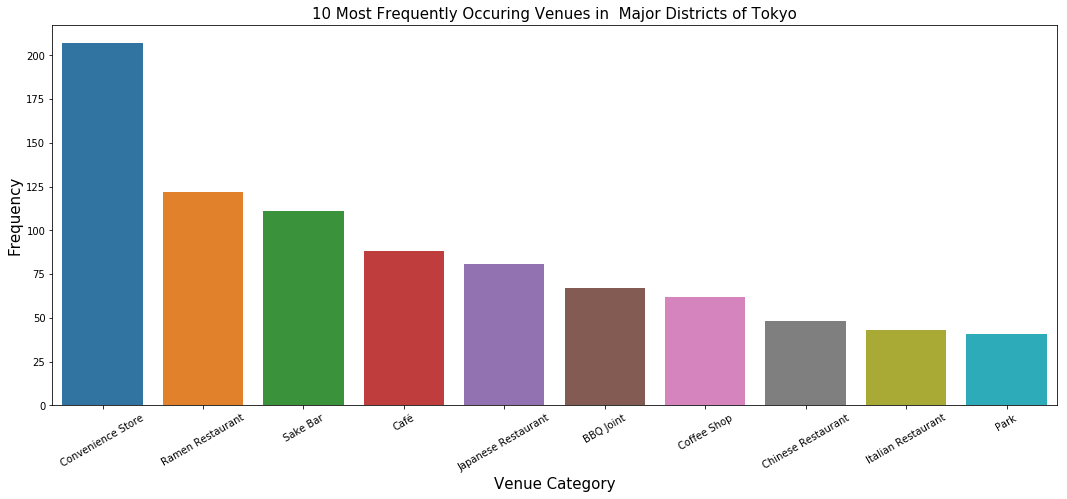

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in  Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()